# BREAKING CAPTCHA

The purpose of this project is to break a CAPTCHA (Completely Automated Public Turing test to tell Computers and Humans Apart). As it is understood from the abbreviation, CAPTCHA is a type of Turing Test developed by Alan Turing who is known as the father of theoretical computer science and artificial intelligence. Turing Test reveals the question whether a computer can think like a human. Based on the definition, an ideal CAPTCHA should be recognized by a human but not by a computer. Generally, it is an image or a sound.

Thanks to developing algorithms and increasing processing power breaking CAPTCHA is getting easier. Within the scope of this project, I will try to break an image CAPTCHA by using the convolutional neural network.


## Import Libraries

You need to download the libraries below to be able to run this project. I used 'pip' to download all the necessary libraries. If you do not have pip, you can refer to https://pip.pypa.io/en/stable/installing/
- Pandas: <font color=green>pip install pandas</font>
- Numpy: <font color=green>pip install numpy</font>
- MatPlotLib: <font color=green>pip install matplotlib</font>
- Tensorflow: <font color=green>pip install tensorflow</font>
- CV2: <font color=green>pip install opencv-python</font>
- SK-Learn: <font color=green>pip install sklearn</font>

In [1]:
import time
import math
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2
import string
import random

from sklearn.metrics import confusion_matrix
from datetime import timedelta

from os import listdir, getcwd
from os.path import isfile, join


/Users/baturay/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Import Train Set, Validation Set and Test Set

The global variables are defined in this section. The following methods can access to these parameters. 

The training data includes 34,275 CAPTCHA images, and the verification data includes 8568 CAPTCHA images. Each image has 280x280 dimensions. For the simplicity, each image contains only one letter with a specific font. The letters consist of 26 lowercase Latin characters. I create the images in grayscale because I want to keep the problem simple. However, the variety of the training set can be increased such as more fonts, colorful images, etc. to find out more patterns.

The label is hidden under the image name of the CAPTCHA. An example file name is ′[0]_1.jpg′ . In this case, 0 is the label where 0 symbolize the letter a.

In [86]:
# Number of color channels for the images: 3 channel for RGB 1 channel for Gray Scale.
# IMPORTANT NOTE: Update num_channels to 1 if you will use filter else change it to 3
num_channels = 1

# square image dimensions (N x N) 
img_size = 50

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
# Each class means one char in English Alphabet. 0 symbolise 'a' class for example
classes = range(0, 26) 
num_classes = len(classes)

# batch size
train_batch_size = 1000 
batch_size = train_batch_size

# validation split
validation_size = .2

train_path = 'captchas/train/'
checkpoint_dir = "models/"

data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Reading training images
Loading 0 classes (Index: 0)
Loading 1 classes (Index: 1)
Loading 2 classes (Index: 2)
Loading 3 classes (Index: 3)
Loading 4 classes (Index: 4)
Loading 5 classes (Index: 5)
Loading 6 classes (Index: 6)
Loading 7 classes (Index: 7)
Loading 8 classes (Index: 8)
Loading 9 classes (Index: 9)
Loading 10 classes (Index: 10)
Loading 11 classes (Index: 11)
Loading 12 classes (Index: 12)
Loading 13 classes (Index: 13)
Loading 14 classes (Index: 14)
Loading 15 classes (Index: 15)
Loading 16 classes (Index: 16)
Loading 17 classes (Index: 17)
Loading 18 classes (Index: 18)
Loading 19 classes (Index: 19)
Loading 20 classes (Index: 20)
Loading 21 classes (Index: 21)
Loading 22 classes (Index: 22)
Loading 23 classes (Index: 23)
Loading 24 classes (Index: 24)
Loading 25 classes (Index: 25)
Size of:
- Training-set:		34275
- Validation-set:	8568


## Function to Plot Captchas

This helping method plots images 3 by 3. It takes images and its labels as an input. Optionally, it can also have predicted label as an input. 

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, -1))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "Label: {0}".format(cls_true[i])
        else:
            xlabel = "Label: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Function to Plot Image

In [4]:
def plot_image(image):
    plt.imshow(image)
    plt.show()
    

### Function to Map Labels

In [5]:
def mapLabel(labels): 
    # Dict object that has ref numbers of letters on keys and chars on values such as {0:'a', 1:'b', ..}
    mapDict = dict(zip([ord(c)%32-1 for c in string.lowercase],string.lowercase))
    mappedLabels = [mapDict[label] for label in labels]
    return mappedLabels

### Plot 9 Samples from Train Data

Show 9 different samples to check whether their labels are correct. 'c' is labelled as 2, it means that it is correctly labeled because it is the 3rd letter in English alphabet.

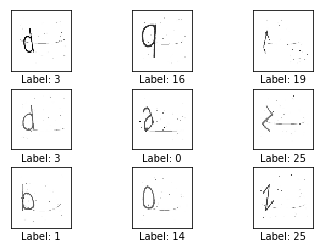

In [6]:
# From train set get sample images and its labels
images, cls_true  = data.train.images, data.train.cls

# Plot the images and its labels
plot_images(images=images, cls_true=mapLabeel(cls_true))

# TENSOR FLOW

For the neural network implementation, I prefer to use tensor flow library. It is an open source software library designed by Google Brain Team. Originally, it is written in C++ but in this project I will use Tensor Flows python wrapper. 

In [7]:
tf.set_random_seed(61) # Define a random seed to find replicable solutions at each run of this project


## Place Holder Variables

This place holder does not have any input for now. It indicates the general structure of the X and y values. This placeholders will be filled by the train and label data at the following sections.

In [8]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x') # Images
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels]) # Re-shape Images
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


Instructions for updating:
Use the `axis` argument instead


## Building Convolutional Neural Network Graph

In this project, I prefer to use convolutional neural networks (CNN) to break CAPTCHA by using TENSORFLOW library. It is a state of the art algorithm for image classification, and it needs less preprocessing compared to other classification algorithms. It is also much faster than dense neural networks because it requires fewer weights and the number of necessary hidden fully connected layers are less.

The main advantage of this algorithm is that it can find high-level features automatically. This is a good aspect of our project because the CAPTCHA images are very noisy.

The algorithm has five main layers which are convolutional, pooling, fully connected and prediction layers. Each layer also may have multiple sub-layers.

### Convolutional Layer & Pooling 1

The primary duty of convolutional layer is to find out the pixel patterns in image classification. If one applies more filters than the probability of finding different patterns increase but the execution time of the algorithm decreases. Convolution layer has kernel parameters, and each kernel helps algorithm to see the patterns.

In this project, I use three convolutional layers and 5x5 kernel matrices at all layers.

Before applying the convolutional layer, I resize the train and validation set images from 280x280x3 shape to 50x50x3.
These resized train images constitute the input of the 1st convolutional layer. The smaller images are better concerning execution time because more dimensions mean more convolution operation for the fixed kernel size. Note that, you may also lose some information if you make image dimensions very small. So, there is a trade-off between execution time and missing data.

For the number of filters, I plan to use 32 filters to find out the patterns of the image.

The pooling layer comes after each convolutional layer to reduce the dimension of the convolutional layer output. I use two by two filter matrix and set the stride parameter to two. It means that this layer divides the output of the convolutional layer into 2x2 pixel matrices and these matrices should not intersect because the stride is two. After division, from each split matrix, only maximum pixel value can pass, and all the others are filtered out. So, from 4 value only one value can , and it reduces the dimension four times. For example, after applying pooling layer on top the 1st convolutional layer, the matrix shape will drop from 50x50x32 to 25x25x32.


In [43]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=x_image,
    filters=32,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)

# Pooling Layer #1
# First max pooling layer with a 2x2 filter and stride of 2
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
print(x_image.shape)
print(conv1)
print(pool1)

(?, 50, 50, 1)
Tensor("conv2d_3/Relu:0", shape=(?, 50, 50, 32), dtype=float32)
Tensor("max_pooling2d_3/MaxPool:0", shape=(?, 25, 25, 32), dtype=float32)


### Convolutional Layer & Pooling 2

Differently, from the 1st convolutional layer, I applied 64 filters instead of 32. The reason is that the input image dimension of the 2nd convolutional layer is 25x25x32 while the input image shape of the 1st convolutional layer is 50x50x3 (skipping pooling effect for now). Because the shape is bigger, I increase the number of filters to find more patterns.

In [10]:
# Convolutional Layer #2
# Computes 64 features using a 5x5 filter.
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)

# Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

print(conv2)
print(pool2)

Tensor("conv2d_1/Relu:0", shape=(?, 25, 25, 64), dtype=float32)
Tensor("max_pooling2d_1/MaxPool:0", shape=(?, 12, 12, 64), dtype=float32)


### Convolutional Layer & Pooling 3

In [11]:
# Convolutional Layer #3
# Computes 64 features using a 5x5 filter.
conv3 = tf.layers.conv2d(
    inputs=pool2,
    filters=64,
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.relu)

# Pooling Layer #2
# Second max pooling layer with a 2x2 filter and stride of 2
pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)

print(conv3)
print(pool3)

Tensor("conv2d_2/Relu:0", shape=(?, 12, 12, 64), dtype=float32)
Tensor("max_pooling2d_2/MaxPool:0", shape=(?, 6, 6, 64), dtype=float32)


### Flatten Layer

After the 3rd pooling layer, the output matrix has 6x6x64 dimensions, and we need to give this matrix to a dense neural network as an input to train our algorithm. The dense neural network only accepts vectors as input. So, at this step, we convert the three-dimensional matrix to a vector.

In [12]:
# Flatten tensor into a batch of vectors
# Input Tensor Shape: [batch_size, 7, 7, 64]
# Output Tensor Shape: [batch_size, 7 * 7 * 64]
pool3_flat = tf.reshape(pool3, [-1, pool3.shape[1].value * pool3.shape[2].value * pool3.shape[3].value])
pool3_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 2304) dtype=float32>

### Fully Connected Layer 1

There are two fully connected layers in this network, and the first layer has 1024 neurons. In this layer, there is a 40% drop out rate to overcome the over-fitting problem. The activation function of this layer is ReLU to handle non-linear relationships.
The second fully connected layer has 26 neurons because we have 26 classes to predict. Each neuron is dedicated to one class.

In [13]:
# Dense Layer
# Densely connected layer with 1024 neurons
# Input Tensor Shape: [batch_size, 7 * 7 * 64]
# Output Tensor Shape: [batch_size, 1024]
fc_layer1 = tf.layers.dense(inputs=pool3_flat, units=1024, activation=tf.nn.relu)
fc_layer1

<tf.Tensor 'dense/Relu:0' shape=(?, 1024) dtype=float32>

### Fully Connected Layer 2

In [14]:
# Add dropout operation; 0.6 probability that element will be kept
dropout = tf.layers.dropout(
    inputs=fc_layer1, rate=0.4)

# Logits layer
# Input Tensor Shape: [batch_size, 1024]
# Output Tensor Shape: [batch_size, 10]
logits = tf.layers.dense(inputs=dropout, units= num_classes)
logits

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 26) dtype=float32>

### Prediction Layer

This layer calculates the probability of each class based on the weights coming from the 2nd fully connected layer. After it calculates all the probabilities, it returns the class that has the highest probability.


In [15]:
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost Function

The cost function of this network is cross entropy. It is a widely used error function in CNN for classification problems. It has some advantages over mean squared error or classification accuracy because it considers the probability distributions of the classes.

In [16]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

### Optimisation Method

The main purpose of the model is to minimize the cost function. In this optimization problem, our objective is cross entropy function. We also know that weights of the hidden layers have a direct effect on objective function. Thus, weights are our decision variables and they need to be adjusted to optimize objective. I use Adam Optimizer as an optimization method. This optimizer is an extended version of the classical stochastic gradient descent algorithm. Adam algorithm maintains the learning rate for each network weight. So, it converges faster than gradient descent algorithm because it uses fixed learning rate.

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [18]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Filter Captchas

### Function to Filter Captchas

In [59]:
def filterImages(im_ids, path):
    filtered_train_images= list()
    for im_id in im_ids:
        im_path = join(getcwd(), path + im_id) # Create path
        im = cv2.imread(im_path) # Read Image
        im = cv2.resize(im, (img_size, img_size), cv2.INTER_LINEAR) # Resize Image
        gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) # Set Gray Color
        _, thresh = cv2.threshold(gray, 248, 255, cv2.THRESH_BINARY_INV) # Set Threshold
        filtered = thresh
        _, contours, _ = cv2.findContours(filtered, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
        mask = np.ones(filtered.shape[:2], dtype="uint8") * 255
        i = 0
        for cnt in contours:
            area = cv2.contourArea(cnt)
            if  area < 4:
                cv2.drawContours(mask, [cnt], -1, 0, -1)
                
        filtered = cv2.bitwise_and(filtered, filtered, mask=mask)       
        
        filtered_train_images.append(filtered) # Add images into filtered_train_images
    filtered_train_images = np.array(filtered_train_images)
    return filtered_train_images

### Plot 9 Random Images of Filtered Train Images

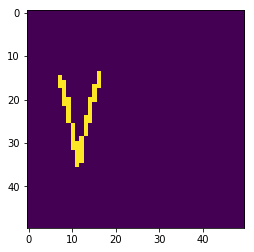

Label v


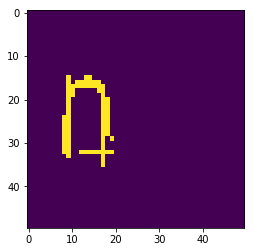

Label n


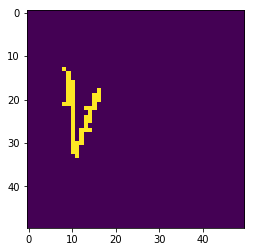

Label v


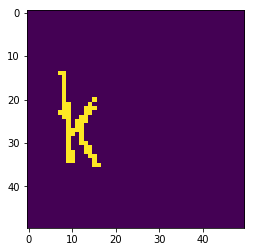

Label k


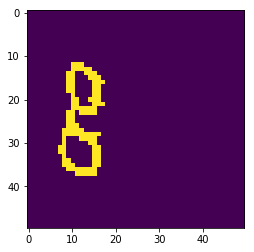

Label g


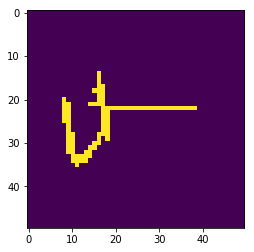

Label u


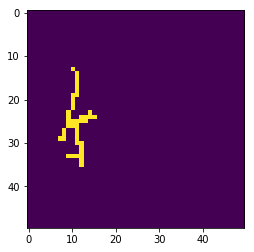

Label k


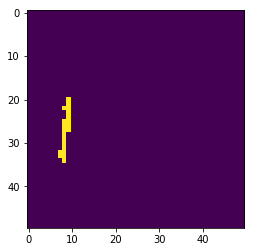

Label i


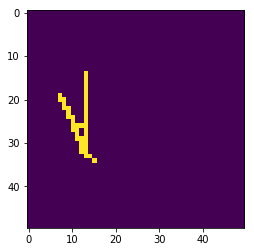

Label v


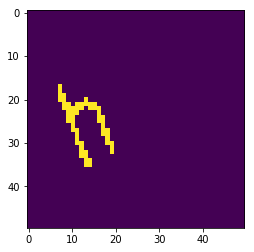

Label h


In [62]:
# Plot random 10 images and its labels
random.seed(61)
random10Ids = [random.randint(1, len(data.train.labels)-1) for _ in range(0,10)]
filtered_train_images = filterImages(data.train.ids[random10Ids],train_path)
for i in range(0,10):
    plot_image(filtered_train_images[i])
    print('Label %s' % mapLabel(data.train.cls)[random10Ids[i]])

## Running Tensor Flow

In [19]:
session = tf.Session()
session.run(tf.global_variables_initializer())


### Optimisation Function

In [23]:
# Counter for total number of iterations performed so far.
total_iterations = 0
def print_optimisation_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))
    
def optimize(num_iterations, useFilter = False):
    
    # update the global variable instead of a local variable.
    global total_iterations
    print('Total Iterations are %s' % str(total_iterations))
    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, x_batch_ids, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, x_valid_ids, valid_cls_batch = data.valid.next_batch(train_batch_size)

        if useFilter:
            x_batch = filterImages(x_batch_ids, train_path) # Filter train batch
            x_valid_batch = filterImages(x_valid_ids, train_path) # Filter test batch
            # Convert shape from [num examples, rows, columns, depth]
            # to [num examples, flattened image shape]  
            x_batch = x_batch.reshape(train_batch_size, img_size_flat)
            x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)
     
        if not useFilter:
            # Convert shape from [num examples, rows, columns, depth]
            # to [num examples, flattened image shape]  
            x_batch = x_batch.reshape(train_batch_size, img_size_flat)
            print(x_batch.shape)
            x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_optimisation_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))


## Training With Filtering

In this section, I train the CNN model with the filtered images. As I explained before CAPTCHA is a Turing Test and during the creation of the CAPTCHA images a lot of noises are added to CAPTCHA images to make recognition harder for the computers but not for the humans. So, there are a lot of dots, meaningless shapes and lines apart from the letters. My purpose is to detect all the meaningless shapes and filter them out.

Even if training data seems in grayscale, it has three channels which are red, green and blue. I first convert three channel to one channel in grayscale to save memory. After, I set a binary threshold to the images. It means that pixels can be either black or white. There cannot be any color in-between. I then find all the contours at a particular image. It sees all the dots, lines, letters and meaningless other shapes. The primary purpose is to keep letters and remove all the other contours. At this point, I calculate the area of each contour and eliminate the contours that have less than a particular area. Thanks to this method, I remove most of the noises from the training images.

After filtering, the model is trained in 800 iterations. At this time, it converges much earlier. The best final performance metrics for training accuracy is 98.7%, 98.6% for validation accuracy, 0.033 for validation loss. The last 10 epochs results are shared below. As you can see from the figure 4, the metrics are converged.

### Performance after 100 optimization iteration for filtered

In [24]:
optimize(num_iterations=100, useFilter = True)


Total Iterations are 0
Epoch 1 --- Training Accuracy:   2.1%, Validation Accuracy:   1.9%, Validation Loss: 12.828
Epoch 2 --- Training Accuracy:  73.6%, Validation Accuracy:  73.6%, Validation Loss: 0.805
Epoch 3 --- Training Accuracy:  93.9%, Validation Accuracy:  93.3%, Validation Loss: 0.234
Time elapsed: 0:22:06


### Performance after 400 optimization iteration for filtered

In [40]:
optimize(num_iterations=300, useFilter = True)

Total Iterations are 100
Epoch 4 --- Training Accuracy:  96.8%, Validation Accuracy:  96.8%, Validation Loss: 0.164
Epoch 5 --- Training Accuracy:  98.2%, Validation Accuracy:  97.2%, Validation Loss: 0.122
Epoch 6 --- Training Accuracy:  98.3%, Validation Accuracy:  97.6%, Validation Loss: 0.101
Epoch 7 --- Training Accuracy:  98.5%, Validation Accuracy:  98.2%, Validation Loss: 0.092
Epoch 8 --- Training Accuracy:  98.6%, Validation Accuracy:  97.7%, Validation Loss: 0.098
Epoch 9 --- Training Accuracy:  98.7%, Validation Accuracy:  97.9%, Validation Loss: 0.073
Epoch 10 --- Training Accuracy:  98.7%, Validation Accuracy:  98.1%, Validation Loss: 0.051
Epoch 11 --- Training Accuracy:  98.7%, Validation Accuracy:  98.3%, Validation Loss: 0.047
Epoch 12 --- Training Accuracy:  98.7%, Validation Accuracy:  97.7%, Validation Loss: 0.057
Time elapsed: 1:07:46


### Performance after 800 optimization iteration for filtered

In [41]:
optimize(num_iterations=400, useFilter = True)

Total Iterations are 400
Epoch 13 --- Training Accuracy:  98.7%, Validation Accuracy:  98.0%, Validation Loss: 0.053
Epoch 14 --- Training Accuracy:  98.7%, Validation Accuracy:  98.3%, Validation Loss: 0.038
Epoch 15 --- Training Accuracy:  98.7%, Validation Accuracy:  98.4%, Validation Loss: 0.041
Epoch 16 --- Training Accuracy:  98.7%, Validation Accuracy:  97.8%, Validation Loss: 0.056
Epoch 17 --- Training Accuracy:  98.7%, Validation Accuracy:  98.0%, Validation Loss: 0.048
Epoch 18 --- Training Accuracy:  98.7%, Validation Accuracy:  98.4%, Validation Loss: 0.034
Epoch 19 --- Training Accuracy:  98.7%, Validation Accuracy:  98.5%, Validation Loss: 0.036
Epoch 20 --- Training Accuracy:  98.7%, Validation Accuracy:  97.8%, Validation Loss: 0.055
Epoch 21 --- Training Accuracy:  98.7%, Validation Accuracy:  98.2%, Validation Loss: 0.045
Epoch 22 --- Training Accuracy:  98.7%, Validation Accuracy:  98.4%, Validation Loss: 0.033
Epoch 23 --- Training Accuracy:  98.7%, Validation Accu

## Training Without Filtering

After building the convolutional neural network, I start training the model. As I mentioned before, our train set has 40,000 CAPTCHA images. I use 80% of this data as train set and the remaining as validation set.
At this section, I keep the noises at the training set. It means that I did not apply any preprocessing or filtering to the training images.

I set the learning rate as 10e − 4 and make 1000 iterations to optimize cross entropy function. Based on these parameters, I obtained 98.7% training accuracy, 98.3% validation accuracy and 0.050% validation loss. The model trained in 2 hours and 40 minutes with dual 2 GHz Intel Core i5. Note that because I do not have a dedicated GPU, I used CPU.

At the end of 1000 iterations, the model still did not converge because the objective function value keeps decreasing. The last 10 epochs results are shared below.


### Performance after 1000 optimization iteration for not filtered

In [42]:
optimize(num_iterations=900, useFilter = False)


Epoch 4 --- Training Accuracy:  78.4%, Validation Accuracy:  75.3%, Validation Loss: 0.948
Epoch 5 --- Training Accuracy:  85.1%, Validation Accuracy:  81.3%, Validation Loss: 0.657
Epoch 6 --- Training Accuracy:  88.3%, Validation Accuracy:  89.1%, Validation Loss: 0.426
Epoch 7 --- Training Accuracy:  91.2%, Validation Accuracy:  89.1%, Validation Loss: 0.389
Epoch 8 --- Training Accuracy:  92.0%, Validation Accuracy:  90.5%, Validation Loss: 0.342
Epoch 9 --- Training Accuracy:  93.3%, Validation Accuracy:  91.4%, Validation Loss: 0.293
Epoch 10 --- Training Accuracy:  94.5%, Validation Accuracy:  94.4%, Validation Loss: 0.198
Epoch 11 --- Training Accuracy:  95.2%, Validation Accuracy:  94.1%, Validation Loss: 0.222
Epoch 12 --- Training Accuracy:  96.1%, Validation Accuracy:  93.9%, Validation Loss: 0.206
Epoch 13 --- Training Accuracy:  96.2%, Validation Accuracy:  94.7%, Validation Loss: 0.180
Epoch 14 --- Training Accuracy:  96.4%, Validation Accuracy:  96.6%, Validation Loss: 

### Save Tensor Flow Model

In [42]:
saver = tf.train.Saver()
# The model for not filtered is saved as captcha_model.ckpt
saver.save(session, "./captcha_model_filtered.ckpt")


'./captcha_model_filtered.ckpt'

### Function to Predict Image Sets

In [44]:
def predictImageSet(imageSet): 
    _feed_dict = {
            x: imageSet.reshape(-1, img_size_flat),
            y_true: np.array([range(0, 26)])
    }
    preds = session.run(y_pred_cls, feed_dict=_feed_dict)
    return preds

### Predict and Visualize 10 Validation Images

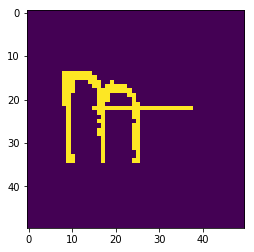

The label of image above is predicted as m


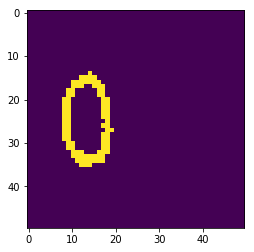

The label of image above is predicted as o


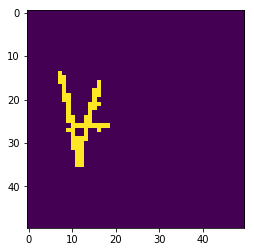

The label of image above is predicted as v


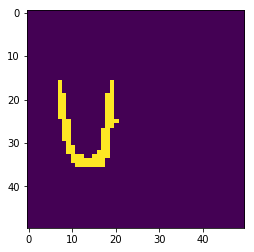

The label of image above is predicted as u


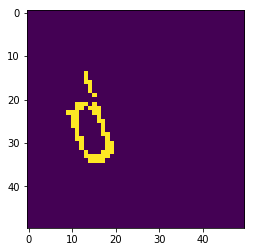

The label of image above is predicted as d


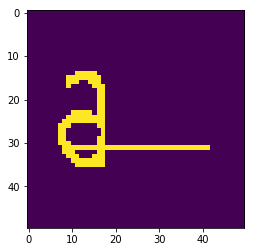

The label of image above is predicted as a


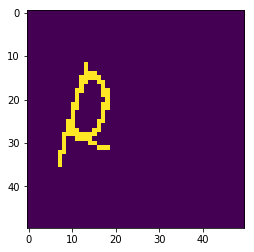

The label of image above is predicted as p


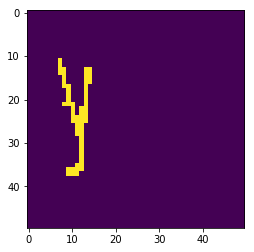

The label of image above is predicted as y


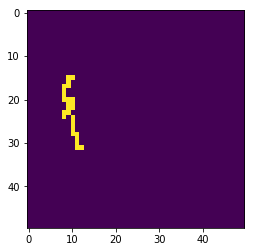

The label of image above is predicted as f


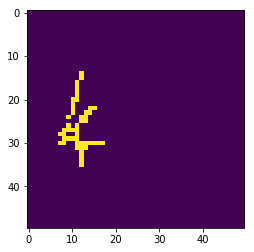

The label of image above is predicted as k


In [81]:
random.seed(61)
random10Ids = [random.randint(1, len(data.valid.labels)-1) for _ in range(0,10)]
filtered_validation_images = filterImages(data.valid.ids[random10Ids],train_path)
pred = predictImageSet(filtered_validation_images)
pred = mapLabel(pred)
for i in range(0,10):
    plot_image(filtered_validation_images[i])
    print('The label of image above is predicted as %s' % pred[i])